# 1. Preprocessamento de Dados e EDA

Os dados que serão preprocessados alimentarão três modelos de Deep Learning para posterior ensemble learning - um para classificar se o texto exibe uma recomendação acionável, um para predizer o sentimento geral do texto e outro para identificar a emoção predominante no texto.

**Estrutura**

* Dados de Recomendação Acionável
    * Carregamento
    * Limpeza
    * Análise Exploratória
    * Preprocessamento
    * Serialização
* Dados de Sentimento Geral
    * Carregamento
    * Limpeza
    * Análise Exploratória
    * Preprocessamento
    * Serialização
* Dados de Emoção Predominante
    * Carregamento
    * Limpeza
    * Análise Exploratória
    * Preprocessamento
    * Serialização

## Configurações iniciais

In [1]:
# Importações de libraries importantes

import pandas as pd
import numpy as np
import re
import pickle as pl
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Funções/Classes auxiliadoras

class Preprocessa:
    
    """
    Uma classe que contém métodos para pré-processar dados de texto.
    """

    def limpa_dados(self, string: str) -> str:
        """
        Limpa a string de entrada removendo caracteres não alfanuméricos e convertendo os
        caracteres restantes em minúsculas.

        Args:
            string (str): A string de entrada a ser limpa.

        Returns:
            str: A string limpa.

        Raises:
            TypeError: Se o tipo de dado de entrada não for uma string.
        """
        self.string = string

        if not isinstance(string, str):
            raise TypeError("O tipo do valor de entrada deveria ser string.")

        final_data = re.sub(r'[^a-zA-Z0-9\s]', '', string)
        final_data = final_data.lower()

        return final_data
    
    def remover_stopwords(self, df: pd.DataFrame, coluna: str) -> pd.DataFrame:
        
        """
        Remove as palavras irrelevantes (stopwords) da coluna especificada em um DataFrame.

        Args:
            df (pd.DataFrame): O DataFrame contendo os dados a serem pré-processados.
            coluna (str): A coluna do DataFrame que contém os dados a serem pré-processados.

        Returns:
            pd.DataFrame: O DataFrame com as stopwords removidas.

        """
        self.df = df
        self.coluna = coluna

        stopwords_ = set(stopwords.words('english'))

        df[coluna] = df[coluna].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_)]))

        return df
    
    def lematizar_texto(self, string: str) -> str:
        """
        Lematiza a string fornecida usando o lematizador WordNetLemmatizer da biblioteca NLTK.

        Args:
            string (str): A string a ser lematizada.

        Returns:
            str: A string lematizada.

        Raises:
            Nenhum.

        Exemplo:
            >>> texto = "Os gatos estão caçando ratos"
            >>> lematizador = Lematizador()
            >>> lematizador.lematizar_texto(texto)
            'O gato estar caçar rato '
        """

        self.string = string
        
        tokenizador = nltk.tokenize.WhitespaceTokenizer()
        lematizador = nltk.stem.WordNetLemmatizer()
        
        st = ""
        
        for word in tokenizador.tokenize(string):
            st = st + lematizador.lemmatize(word) + " "
        
        return st
        

## Dados de Recomendação Acionável

### Carregamento

In [3]:
# Dados da Wikihow
wikihow = pd.read_csv("../dados/raw/dados_recomendacao/wikihow_dataset.csv")
wikihow = pd.DataFrame(wikihow["text"].values, columns=["text"])

In [4]:
wikihow

,text
0,"If you're a photographer, keep all the necess..."
1,See the image for how this drawing develops s...
2,It is possible to become a VFX artist without...
3,The best art investors do their research on t...
4,"As you start planning for a project or work, ..."
...,...
215360,"If you have a name that you like, you might f..."
215361,Your name might sound great to you when you s...
215362,Relief printing is the oldest and most tradit...
215363,"Intaglio is Italian for ""incis­ing,"" and corr..."


### Limpeza

In [5]:
# Palavras que o texto precisa incluir para ser selecionado
palavras_chave = ["strengthen", "refine", "enhance", "craft",
                  "optimize", "upgrade", "expand", "simplify", 
                  "diversify", "customize", "adding", "incorporating"]

In [6]:
# Substitui valores NaN por espaços vazios
wikihow['text'] = wikihow['text'].fillna('')

# Seleciona os textos com base na presença das palavras-chave
mask = wikihow['text'].str.contains('|'.join(palavras_chave))
wikihow = wikihow[mask]

In [7]:
# Cria coluna label e seta como 1
wikihow["label"] = 1

C:\Users\Kayky\AppData\Local\Temp\ipykernel_35732\2310741275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wikihow["label"] = 1


In [8]:
wikihow

,text,label
0,"If you're a photographer, keep all the necess...",1
1,See the image for how this drawing develops s...,1
3,The best art investors do their research on t...,1
4,"As you start planning for a project or work, ...",1
29,"Cleaning, feeding, grooming, exercising, and ...",1
...,...,...
215353,"Don't argue about the price, just look at you...",1
215357,"Youth theatres, amateur organizations and sch...",1
215358,The arts are about creativity and self-expres...,1
215359,You may have been called something other than...,1


In [9]:
# Dados da Tripadvisor
trip = pd.read_csv("../dados/raw/dados_recomendacao/tripadvisor_dataset.csv")
trip = pd.DataFrame(trip["Review"].values, columns=["Review"])

In [10]:
trip

,Review
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso..."
...,...
20486,"best kept secret 3rd time staying charm, not 5..."
20487,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ..."
20489,hotel theft ruined vacation hotel opened sept ...


In [11]:
# Substitui valores NaN por espaços vazios
trip['Review'] = trip['Review'].fillna('')

# Filtrando conjunto de dados para não incluir as palavras chave
mask2 = trip['Review'].str.contains('|'.join(palavras_chave))
trip = trip[~mask2]

In [12]:
trip

,Review
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso..."
...,...
20486,"best kept secret 3rd time staying charm, not 5..."
20487,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ..."
20489,hotel theft ruined vacation hotel opened sept ...


In [13]:
trip["label"] = 0

C:\Users\Kayky\AppData\Local\Temp\ipykernel_35732\2262714074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip["label"] = 0


In [14]:
# Renomeação de coluna

novo_nome = {'Review': 'text'}
trip = trip.rename(columns=novo_nome)

In [15]:
trip

,text,label
0,nice hotel expensive parking got good deal sta...,0
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,0
3,"unique, great stay, wonderful time hotel monac...",0
4,"great stay great stay, went seahawk game aweso...",0
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",0
20487,great location price view hotel great quick pl...,0
20488,"ok just looks nice modern outside, desk staff ...",0
20489,hotel theft ruined vacation hotel opened sept ...,0


In [16]:
'''
Mergindo conjuntos de dados
'''

# Concatena os datasets

df = pd.concat([wikihow, trip])

# Reseta o índice dos datasets

df = df.reset_index()
df = df.iloc[:, 1:]

In [17]:
df

,text,label
0,"If you're a photographer, keep all the necess...",1
1,See the image for how this drawing develops s...,1
2,The best art investors do their research on t...,1
3,"As you start planning for a project or work, ...",1
4,"Cleaning, feeding, grooming, exercising, and ...",1
...,...,...
48013,"best kept secret 3rd time staying charm, not 5...",0
48014,great location price view hotel great quick pl...,0
48015,"ok just looks nice modern outside, desk staff ...",0
48016,hotel theft ruined vacation hotel opened sept ...,0


### Análise Exploratória

In [49]:
# Contagem das labels
label_counts = df['label'].value_counts()
label_counts

1    29069
0    18949
Name: label, dtype: int64

[Text(0.5, 1.0, 'Distribuição das Labels')]

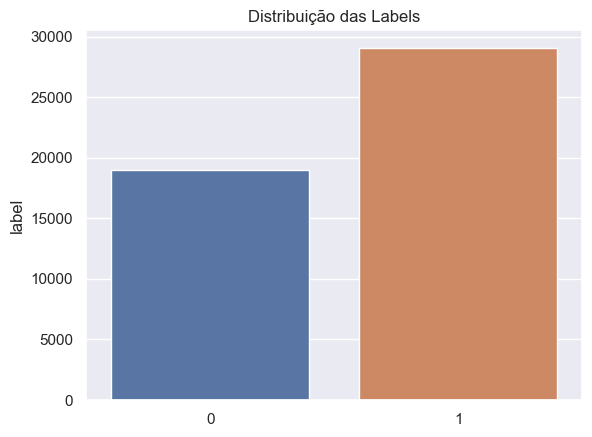

In [51]:
# Plot das labels
sns.set()
sns.barplot(x=[1, 0], y=label_counts).set(title="Distribuição das Labels")

In [57]:
'''
Wordclouds
'''

# Filtrando o dataset e criando sub-datasets com label = 1 e label = 0
label_1 = df.query("label == 1")
label_0 = df.query("label == 0")


# Transformando numa string única
def transforma_string_unica(dados):
    
    dados = dados["text"].values
    dados = " ".join(dados)
    
    return dados

label_1 = transforma_string_unica(label_1)
label_0 = transforma_string_unica(label_0)

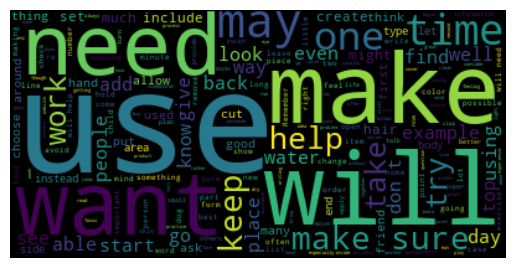

In [58]:
# Mostrando a WordCloud da label 1
wordcloud_label_1 = WordCloud().generate(label_1)
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.axis("off")
plt.show()

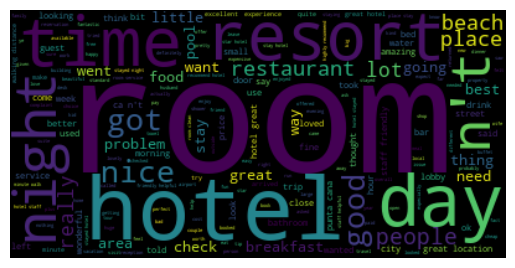

In [59]:
# Mostrando a WordCloud da label 0
wordcloud_label_0 = WordCloud().generate(label_0)
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.axis("off")
plt.show()

### Preprocessamento

In [18]:
df

,text,label
0,"If you're a photographer, keep all the necess...",1
1,See the image for how this drawing develops s...,1
2,The best art investors do their research on t...,1
3,"As you start planning for a project or work, ...",1
4,"Cleaning, feeding, grooming, exercising, and ...",1
...,...,...
48013,"best kept secret 3rd time staying charm, not 5...",0
48014,great location price view hotel great quick pl...,0
48015,"ok just looks nice modern outside, desk staff ...",0
48016,hotel theft ruined vacation hotel opened sept ...,0


In [19]:
# Limpa os dados (remove alfanuméricos, transforma em minúsculo, etc)
df['text'] = df['text'].apply(lambda texto: Preprocessa().limpa_dados(texto))

In [20]:
# Remove palavras desnecessárias
df = Preprocessa().remover_stopwords(df, 'text')

In [21]:
# Lematiza as strings (extrai a raiz das palavras)
df['text'] = df['text'].apply(lambda texto: Preprocessa().lematizar_texto(texto))

In [22]:
df

,text,label
0,youre photographer keep necessary lens cord ba...,1
1,see image drawing develops stepbystep however ...,1
2,best art investor research piece art buy someo...,1
3,start planning project work youll likely gathe...,1
4,cleaning feeding grooming exercising ensuring ...,1
...,...,...
48013,best kept secret 3rd time staying charm 5star ...,0
48014,great location price view hotel great quick pl...,0
48015,ok look nice modern outside desk staff nt part...,0
48016,hotel theft ruined vacation hotel opened sept ...,0


In [23]:
# Arrays do Numpy
recomendacao_texto = df['text'].to_numpy()
recomendacao_label = df['label'].to_numpy()

In [26]:
# Tokenização das palavras

oov_token = '<OOV>'
recomendacao_tokenizador = Tokenizer(oov_token=oov_token)
recomendacao_tokenizador.fit_on_texts(recomendacao_texto)

In [27]:
# Tamanho do vocabulário de recomendação

recomendacao_tamanho_vocab = len(recomendacao_tokenizador.word_counts)
print(f"A quantidade de tokens é: {len(recomendacao_tokenizador.word_counts)}")

A quantidade de tokens é: 255407


In [28]:
# Transforma texto em sequência usando word2index

recomendacao_sequencia = recomendacao_tokenizador.texts_to_sequences(recomendacao_texto)

In [29]:
# Padding das sequencias
tamanho_frase = 1000
recomendacao_padded = pad_sequences(recomendacao_sequencia, maxlen=tamanho_frase, padding='post', truncating='post')

In [30]:
recomendacao_padded

array([[  17, 4125,   28, ...,    0,    0,    0],
       [  53,  420, 1166, ...,    0,    0,    0],
       [  41,  655, 2666, ...,    0,    0,    0],
       ...,
       [ 906,   27,  110, ...,    0,    0,    0],
       [  14, 7056, 6837, ...,    0,    0,    0],
       [  24,  834, 1433, ...,    0,    0,    0]])

### Serialização

In [32]:
'''
Serializa datasets de recomendação
'''

# Texto
pl.dump(recomendacao_padded, open("../dados/preprocessados/recomendacao_texto.pkl", "wb"))
# Label
pl.dump(recomendacao_label, open("../dados/preprocessados/recomendacao_label.pkl", "wb"))

## Dados de Sentimento Geral

### Carregamento

In [47]:
geral = pd.read_csv("../dados/raw/dados_geral/sentiment_dataset.csv", encoding="latin-1", header=None)

In [48]:
geral

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Limpeza

In [49]:
# Remove colunas desnecessárias
geral = geral.iloc[:, [0, 5]]

In [50]:
# Nomeia colunas corretamente
geral = geral.rename(columns={0: 'label', 5: 'text'})

In [51]:
geral

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [52]:
# Troca as labels para 0 e 1

geral['label'] = geral['label'].replace([0, 4], [0, 1])

In [53]:
geral

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


### Análise Exploratória

In [12]:
# Contagem das labels
label_counts = geral['label'].value_counts()
label_counts

0    800000
1    800000
Name: label, dtype: int64

[Text(0.5, 1.0, 'Distribuição das Labels')]

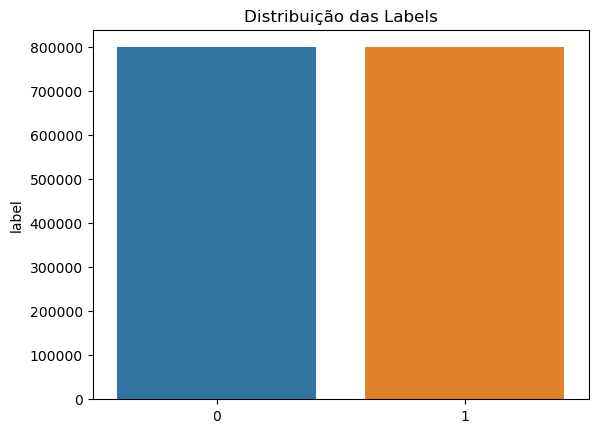

In [13]:
# Plot das labels

sns.barplot(x=[1, 0], y=label_counts).set(title="Distribuição das Labels")

In [14]:
'''
Wordclouds
'''

# Filtrando o dataset e criando sub-datasets com label = 1 e label = 0
label_1 = geral.query("label == 1")
label_0 = geral.query("label == 0")


# Transformando numa string única
def transforma_string_unica(dados):
    
    dados = dados["text"].values
    dados = " ".join(dados)
    
    return dados

label_1 = transforma_string_unica(label_1)
label_0 = transforma_string_unica(label_0)

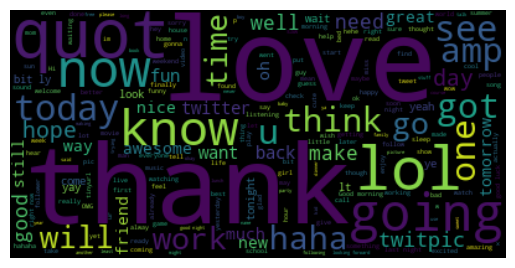

In [48]:
# Mostrando a WordCloud da label 1
wordcloud_label_1 = WordCloud().generate(label_1)
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.axis("off")
plt.show()

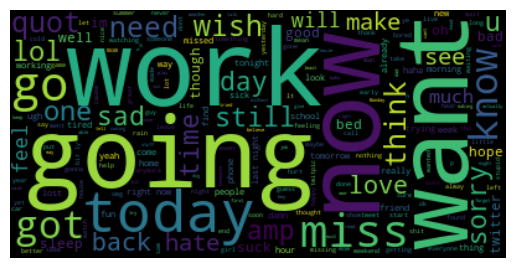

In [49]:
# Mostrando a WordCloud da label 0
wordcloud_label_0 = WordCloud().generate(label_0)
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.axis("off")
plt.show()

### Preprocessamento

In [54]:
geral_1 = geral.query("label == 1")

In [55]:
geral_1

,label,text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [56]:
palavras_chave = ["Joyful", "my", "Optimistic", "Grateful", "Compassionate", "Confident", "Courageous", "Empathetic", "Creative", "Generous", "Humorous", "Enthusiastic", "Inspirational", "Motivated", "Passionate", "Resilient", "Supportive", "Understanding", "Authentic", 
                  "Appreciative", "Empowered", "Admiring", "Blissful", "Calm", "Cheerful", "Delightful", "Eager", "Excited", "Fulfilled", 
                  "Glowing", "Harmonious", "Hopeful", "Kindhearted", "Loving", "Good", "Love", "Abundant", "Affectionate", "Amazing", "Blessed", "Brave", "Captivating", "Charming", "Confidant", "Dazzling", "Determined", "Dynamic", "Elegant", "Empowered", "Energetic", "Exquisite", "Fabulous", "Fearless", "Flourishing", "Glorious", "Graceful",
                  "Happy", "Harmonious", "Heartfelt", "Hopeful", "Imaginative", "Inspiring", "Intuitive", "Joyous", "Magical", "Majestic", "Miraculous", "Passionate", "Radiant", "Reliable", "Sincere", "Sparkling", "Spirited", "Thriving", "Vibrant", "Accomplished", "Adaptable", "Amiable", "Balanced", "Brilliant", "Candid", "Cheerful", "Confident", "Cooperative", "Courageous", "Dedicated", "Dependable", "Dynamic", "Easygoing", "Efficient", "Empathetic", "Enthusiastic",
                  "Friendly", "Generous", "Genuine", "Grateful", "Hardworking", "Helpful", "Honest", "Hopeful", "Humble", "Independent", "Inspiring", "Joyful", "Kind", "Motivated", "Open-minded", "Optimistic", "Passionate", "Patient", "Perceptive", "Positive", "Respectful", "Self-disciplined", "Sincere", "Trustworthy", "Adventurous", "Affable", "Appreciative", "Authentic", "Bright", "Capable", "Caring", "Charismatic", "Compassionate", "Composed", "Considerate", "Courteous", "Creative", "Curious", "Determined", 
                  "Easy to talk to", "Effervescent", "Empowered", "Encouraging", "Endearing", "Energetic", "Engaging", "Enlightened", "Fair", "Focused", "Forgiving", "Friendly", "Fun-loving", "Generous", "Genuine", "Gracious", "Grounded", "Happy", "Hardworking", "Harmonious", "Helpful", "Humble", "Imaginative", "Impartial", "Independent", "Innovative", "Inspiring", "Intelligent", "Intuitive", "Kind-hearted", "Lively", "Loving", "Mature", "Methodical", "Mindful", "Nurturing", "Optimistic", "Passionate", "Patient", 
                  "Persistent", "Pleasant", "Polite", "Practical", "Proactive", "Productive", "Progressive", "Punctual", "Radiant", "Reliable"]

In [57]:
mask = geral_1['text'].str.contains('|'.join(palavras_chave))
geral_1 = geral_1[mask]
geral_1

,label,text
800001,1,im meeting up with one of my besties tonight! ...
800004,1,@LovesBrooklyn2 he has that effect on everyone
800005,1,@ProductOfFear You can tell him that I just bu...
800015,1,Just added tweetie to my new iPhone
800019,1,"Dancing around the room in Pjs, jamming to my ..."
...,...,...
1599982,1,@thrillmesoon i figured out how to see my twee...
1599984,1,You heard it here first -- We're having a girl...
1599986,1,@tarayqueen too much ads on my blog.
1599991,1,@rmedina @LaTati Mmmm That sounds absolutely ...


In [58]:
geral_0 = geral.query("label == 0")
geral_0

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
799995,0,Sick Spending my day laying in bed listening ...
799996,0,Gmail is down?
799997,0,rest in peace Farrah! So sad
799998,0,@Eric_Urbane Sounds like a rival is flagging y...


In [59]:
palavras_chave_2 = ["Aloof", "my", "Anxious", "Arrogant", "Belligerent", "Bitter", "Blunt", "Boastful", "Boring", "Callous", "Careless", "Closed-minded", "Cold", "Combative", "Conceited", "Confused", "Contradictory", "Controlling", "Cowardly", "Critical", "Cynical", "Defensive", "Demanding", "Dependent", "Desperate", "Detached", "Dictatorial", "Difficult", "Disappointing", "Discouraging", "Disrespectful", "Distracted", "Dominating", "Dramatic", "Dull", "Egotistical", "Envious", "Erratic", "Exhausting", "Fake", "Foolish", "Forgetful", "Frustrating", "Gloomy", "Greedy", "Grouchy", "Hateful", "Haughty", 
                    "Hesitant", "Hostile", "Ignorant", "Impatient", "Inattentive", "Inconsiderate", "Indecisive", "Indifferent", "Insecure", "Insincere", "Intolerant", "Irresponsible", "Jealous", "Lazy", "Manipulative", "Materialistic", "Miserable", "Misleading", "Moody", "Narrow-minded", "Needy", "Nervous", "Obnoxious", "Overbearing", "Overcritical", "Overemotional", "Pessimistic", "Possessive", "Procrastinating", "Rude", "Sarcastic", "Self-centered", "Self-doubting", "Selfish", "Skeptical", "Sloppy", "Slow", "Stubborn", "Superficial", "Suspicious", "Temperamental", "Unapproachable", "Uncooperative", 
                    "Unenthusiastic", "Unforgiving", "Unreliable", "Unsympathetic", "Vague", "Vindictive", "Wasteful", "Annoying AF", "Assholish", "Avoidable", "Basic", "Bitchy", "Blah", "Blaming", "Bothersome", "Bratty", "Butthurt", "Cantankerous", "Chaos-inducing", "Chatty", "Cheesy", "Clumsy", "Cocky", "Cold-hearted", "Complicated", "Cranky", "Cringe-worthy", "Crying", "Cursing", "Cynical AF", "Demeaning", "Depressing", "Disappointing AF", "Disgusting", "Distrustful", "Divisive", "Dramatic AF", "Dull AF", "Dumb", "Emotional AF", "Entitled", "Exasperating", "Fake AF", "Frustrating AF", "Fussy", "Gloomy AF", "Greedy AF", "Grumpy", "Harsh", "Heartless", "High-maintenance", "Hissy", "Hopeless", "Hypocritical", "Inconvenient", "Indecisive AF", "Indifferent AF", "Inferior", "Insensitive", "Insecure AF", "Intolerant AF", "Irritating AF", "Jealous AF", "Jerkish", "Judgmental", "Lazy AF", "Liar", "Life-sucking", "Loud-mouthed", 
                    "Low-energy", "Mean-spirited", "Messy", "Mind-numbing", "Mischievous", "Miserable AF", "Moody AF", "Mundane", "Nagging", "Nasty", "Negative AF", "Neurotic", "Noisy", "Nonsensical", "Obnoxious AF", "Offensive", "Out-of-touch", "Overbearing AF", "Overcritical AF", "Overemotional AF", "Overreacting", "Paranoid AF", "Passive-aggressive", "Pathetic", "Pessimistic AF", "Phony", "Pissy", "Pitiful", "Prickly", "Quarrelsome", "Raging", "Ranting", "Ratty", "Repetitive", "Resentful", "Ridiculous", "Rough", "Rowdy", "Rude AF", "Sad-sack", "Sarcastic AF", "Self-absorbed", "Self-centered AF", "Self-doubting AF", "Selfish AF", "Shameful", "Shitty", "Short-tempered", "Skeptical AF", "Sloppy AF", "Slow AF", "Sour", "Spiteful", "Stingy", "Stressed-out", "Stubborn AF", "Superficial AF", "Suspicious AF", "Tantrum-throwing", "Teary", 
                    "Terrible", "Testy", "Thick-headed", "Thorny", "Tiresome", "Toxic AF", "Trivial", "Troublesome", "Unappreciative", "Uncooperative AF", "Undependable", "Unemotional", "Unforgiving AF", "Ungrateful", "Unhelpful", "Uninteresting", "Unpredictable", "Unreliable AF", "Unsociable", "Unsympathetic AF", "Untrustworthy", "Upsetting AF", "Useless", "Vain", "Vengeful", "Wasteful AF", "Weak", "Whining", "Whiny"]

In [60]:
mask = geral_0['text'].str.contains('|'.join(palavras_chave_2))
geral_0 = geral_0[mask]
geral_0

,label,text
1,0,is upset that he can't update his Facebook by ...
3,0,my whole body feels itchy and like its on fire
11,0,I just re-pierced my ears
19,0,@FakerPattyPattz Oh dear. Were you drinking ou...
21,0,"one of my friend called me, and asked to meet ..."
...,...,...
799985,0,"ugh, all my pics r too bog 4 twitter"
799986,0,I feel so dumb because my host so smart at al...
799989,0,Just payed my WAY OVERDUE zta dues. Goodbye $3...
799992,0,@koolgirl37 read my tweet below


In [61]:
geral = pd.concat([geral_0, geral_1])
geral

,label,text
1,0,is upset that he can't update his Facebook by ...
3,0,my whole body feels itchy and like its on fire
11,0,I just re-pierced my ears
19,0,@FakerPattyPattz Oh dear. Were you drinking ou...
21,0,"one of my friend called me, and asked to meet ..."
...,...,...
1599982,1,@thrillmesoon i figured out how to see my twee...
1599984,1,You heard it here first -- We're having a girl...
1599986,1,@tarayqueen too much ads on my blog.
1599991,1,@rmedina @LaTati Mmmm That sounds absolutely ...


In [62]:
# Limpa os dados (remove alfanuméricos, transforma em minúsculo, etc)
geral['text'] = geral['text'].apply(lambda texto: Preprocessa().limpa_dados(texto))

In [63]:
# Remove palavras desnecessárias
geral = Preprocessa().remover_stopwords(geral, 'text')

In [64]:
# Lematiza as strings (extrai a raiz das palavras)
geral['text'] = geral['text'].apply(lambda texto: Preprocessa().lematizar_texto(texto))
geral

,label,text
1,0,upset cant update facebook texting might cry r...
3,0,whole body feel itchy like fire
11,0,repierced ear
19,0,fakerpattypattz oh dear drinking forgotten tab...
21,0,one friend called asked meet mid valley todayb...
...,...,...
1599982,1,thrillmesoon figured see tweet facebook status...
1599984,1,heard first girl hope look wendys brain kiddin...
1599986,1,tarayqueen much ad blog
1599991,1,rmedina latati mmmm sound absolutely perfect s...


In [66]:
# Arrays do Numpy
geral_texto = geral['text'].to_numpy()
geral_label = geral['label'].to_numpy()

In [67]:
# Tokenização das palavras

oov_token = '<OOV>'
geral_tokenizador = Tokenizer(oov_token=oov_token)
geral_tokenizador.fit_on_texts(geral_texto)

In [68]:
# Tamanho do vocabulário de recomendação

geral_tamanho_vocab = len(geral_tokenizador.word_counts)
print(f"A quantidade de tokens é: {geral_tamanho_vocab}")

A quantidade de tokens é: 237878


In [69]:
# Transforma texto em sequência usando word2index

geral_sequencia = geral_tokenizador.texts_to_sequences(geral_texto)

In [70]:
# Padding das sequencias
tamanho_frase = 1000
geral_padded = pad_sequences(geral_sequencia, maxlen=tamanho_frase, padding='post', truncating='post')

In [71]:
geral_padded

array([[   630,     11,    224, ...,      0,      0,      0],
       [   307,    384,     42, ...,      0,      0,      0],
       [ 14554,    503,      0, ...,      0,      0,      0],
       ...,
       [ 62111,     39,   1777, ...,      0,      0,      0],
       [237879,  60164,   2048, ...,      0,      0,      0],
       [    23,  26585,     66, ...,      0,      0,      0]])

### Serialização

In [72]:
'''
Serializa datasets gerais
'''

# Texto
pl.dump(geral_padded, open("../dados/preprocessados/geral_texto.pkl", "wb"))
# Label
pl.dump(geral_label, open("../dados/preprocessados/geral_label.pkl", "wb"))